In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0" # set to "" if on CPU
#importing TARDIS
%pylab inline
from tardis import *

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0
Running TARDIS 2.1...


Using TensorFlow backend.


## Initializing the Universe

The core object of TARDIS is a "universe" class which contains the key characteristics of our model, including the physical box size (bs), the pixel resolution (nc), the fiducial powerspectra (ipklin), the redshift (z_f), astrophysical parameters, and the evolution operator. 

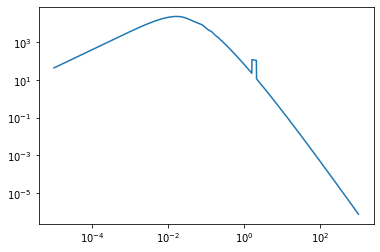

In [2]:
klin = np.loadtxt('F:/学习/天体物理/tardis-tf-master/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('F:/学习/天体物理/tardis-tf-master/data/Planck15_a1p00.txt').T[1]

plin[1300:1330] += 100#100
#print(klin)
#loglog(klin)
plt.loglog(klin,plin)
ipklin = iuspline(klin, plin)

In [3]:
n=32
uni = universe(bs=n, nc=n,z_f=2.0,ipklin = ipklin )
uni.evolv() #run the simulation

(32, 32, 32)
32768 65 32768
Total run time 4.028981924057007


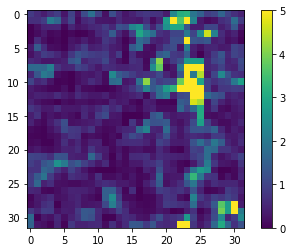

In [4]:
#A slice in real space density
imshow(uni.final_true[0,1],vmax=5)
colorbar()
# local overdensity

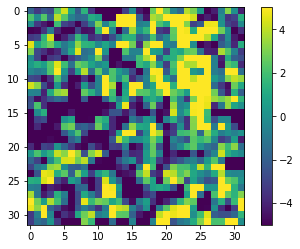

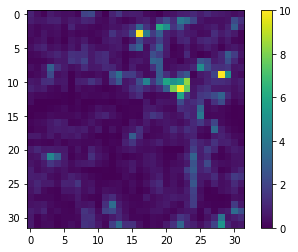

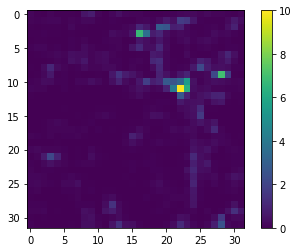

In [5]:
#A slice in real space density
imshow(uni.linear_true[0,0],vmin=-5,vmax=5)
colorbar()
plt.show()

imshow(uni.final_true[0,0],vmin=0,vmax=10)
colorbar()
plt.show()

imshow(uni.final_tau_RSD[0,0],vmin=0,vmax=10)
colorbar()
plt.show()

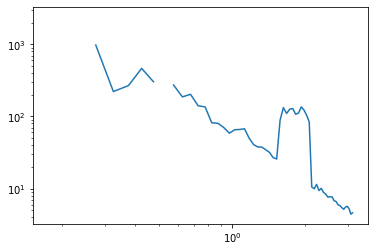

In [7]:
plt.loglog(uni.pk_true[0],uni.pk_true[1])
plt.show()

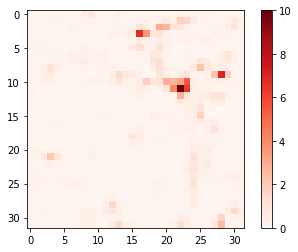

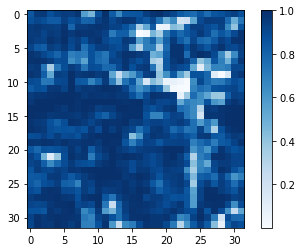

In [8]:
#A slice in redshift space optical depth
imshow(uni.final_tau_RSD[0,0],cmap="Reds",vmax=10)
colorbar()
show()
#or Flux
imshow(np.exp(-1*uni.final_tau_RSD[0,0]),cmap="Blues")
colorbar()
show()

## Mock Observables

Currently there are two main mock observables implemented; a spectroscopic galaxy survey and a lyman alpha forest survey. 

The galaxy survey is very rudimentary and just monte-carlo samples over the universe's RSD galaxy field. For pretty much any real scientific purpose, you should use a more nuianced galaxy catalog from the mock.

The lyman alpha survey randomly picks lines of sight which pass entirely through the volume (no sources are in the volume itself) and applies a powerlaw signal to noise distribution to each LOS based on some given distribution. 

### Lyman Alpha 

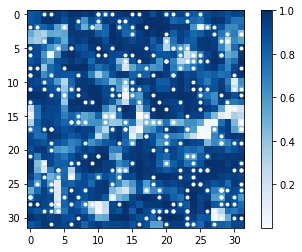

In [10]:
n_los = 300
mock_lya = lya_survey(uni,2,10,sm=0.5,n_skewers=n_los)
#powerlaw distribution of noise from snr_min = 2 to snr_max = 10
mock_lya.select_skewers()
#selecting LOS

imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='white',marker='.')
#plot showing positions of LOS

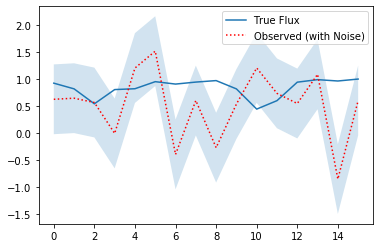

In [403]:
i=2
plt.plot(x,mock_lya.vals_lya.reshape(-1,n)[i],label="True Flux")
fill_between(x,d[i]+diag(N)[i*n:i*n+n]**0.5,d.reshape(-1,n)[i]-diag(N)[i*n:i*n+n]**0.5,alpha=0.2)
plt.plot(x,d[i],"r:",label="Observed (with Noise)")
legend()

In [11]:
from mpl_toolkits.mplot3d import Axes3D

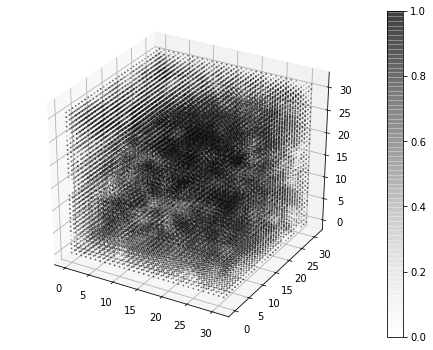

In [13]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
F=exp(-tau.flatten())
cbar = ax1.scatter(X,Y,Z,c=F,alpha=0.5,s=F,cmap='Greys',marker='o')
colorbar(cbar,ax=ax1)
show()

In [15]:
data_coords = mock_lya.skewers_fin
data_coords.shape

(9600, 3)

In [ ]:
d = mock_lya.vals_observed.reshape(-1,n)
sigma2 = np.cov(d.flatten())

In [18]:
def C_md(m,d):
    L_para = n/np.sqrt(n_los)
    L_prep = n/np.sqrt(n_los)
    matrix = np.zeros(shape=(len(m.flatten()),len(d.flatten())))
    a=0
    for i,p1 in enumerate(map_coords):
        a_temp = i//100
        m_x = p1[0]
        m_y = p1[1]
        m_z = p1[2]
        for j,p2 in enumerate(data_coords):
            d_x = p2[0]
            d_y = p2[1]
            d_z = p2[2]

            r_para2 = (m_z-d_z)**2
            r_prep2 = (m_x-d_x)**2+(m_y-d_y)**2
            matrix[i,j] = sigma2*np.exp(-r_para2/L_para**2)*np.exp(-r_prep2/L_para**2)
        if a_temp!=a:
            a=a_temp
            print(a,end=' ')
    return matrix

In [35]:
n/np.sqrt(n_los)

1.8475208614068022

In [24]:
d_los = n/np.sqrt(n_los)
L_para = d_los
L_prep = d_los
matrix = np.zeros(shape=(len(d.flatten()),len(d.flatten())))
def C_dd(d):
    a=0
    for i,p1 in enumerate(data_coords):
        a_temp = i//100
        d1_x = p1[0]
        d1_y = p1[1]
        d1_z = p1[2]
        for j,p2 in enumerate(data_coords):
            d2_x = p2[0]
            d2_y = p2[1]
            d2_z = p2[2]

            r_para2 = (d1_z-d2_z)**2
            r_prep2 = (d1_x-d2_x)**2+(d1_y-d2_y)**2
            matrix[i,j] = sigma2*np.exp(-r_para2/L_para**2)*np.exp(-r_prep2/L_para**2)
        if a_temp!=a:
            a=a_temp
            print(a,end=' ')
    return matrix

In [21]:
m = np.zeros(shape=(n,n,n))
data_coords = mock_lya.skewers_fin
map_x,map_y,map_z = meshgrid(arange(0,n),arange(0,n),arange(0,n))
map_coords = np.vstack(list(map(np.ravel, [map_x,map_y,map_z]))).T
sigma2 = np.cov(d.flatten())

In [22]:
C_MD = C_md(m,d)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [25]:
C_DD = C_dd(d)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 

In [26]:
noise=mock_lya.inverse_covar
N = 1/noise.values
N = diagflat(N)

In [27]:
M = np.dot(np.dot(C_MD,inv(C_DD+N)),d.flatten())
M_final=M.reshape(n,n,n)

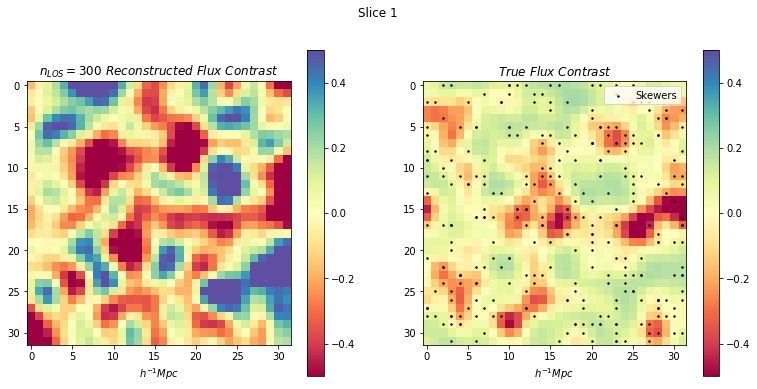

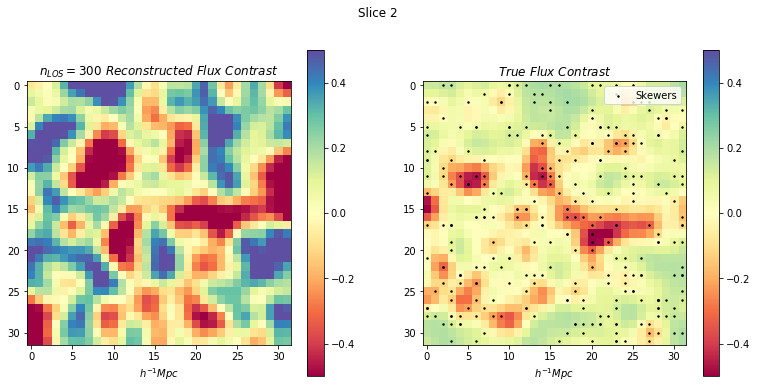

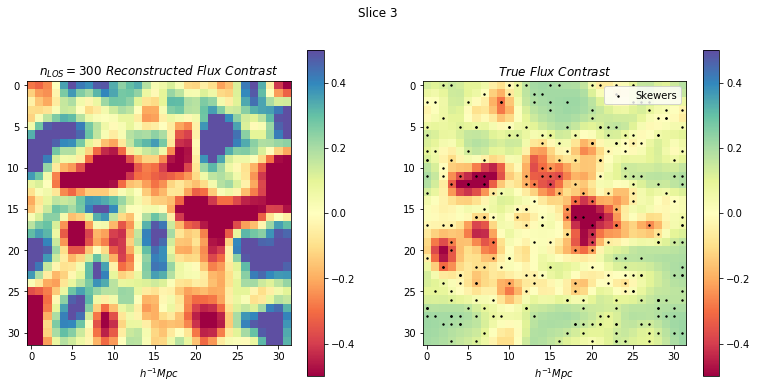

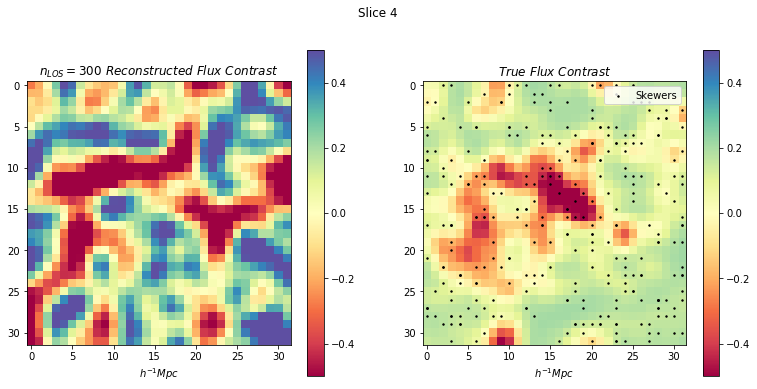

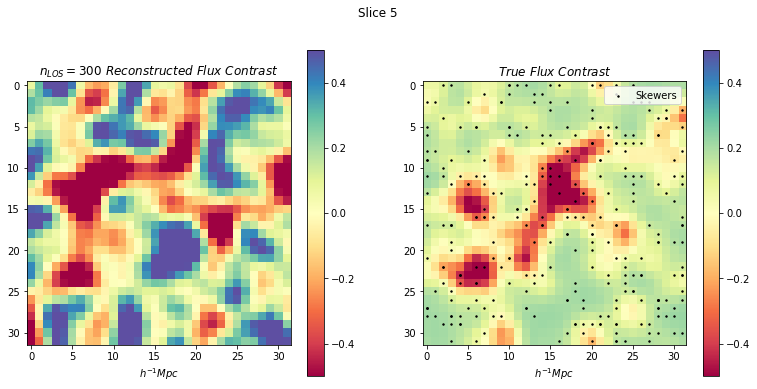

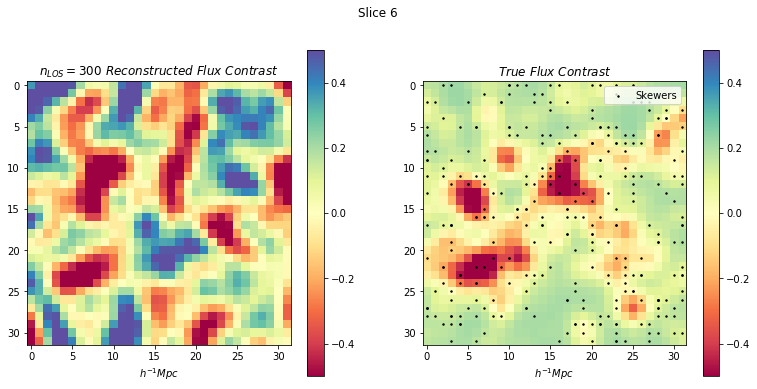

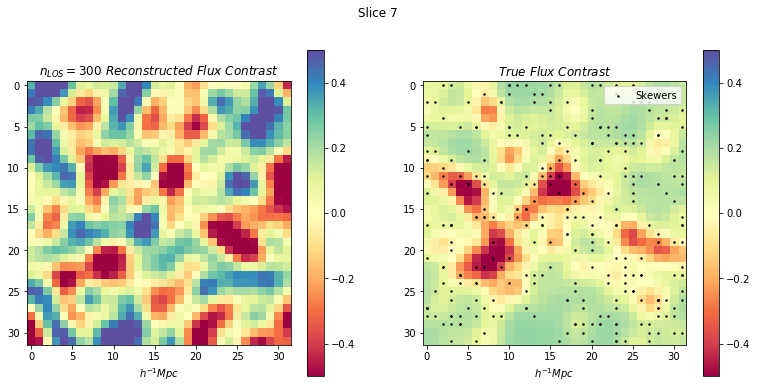

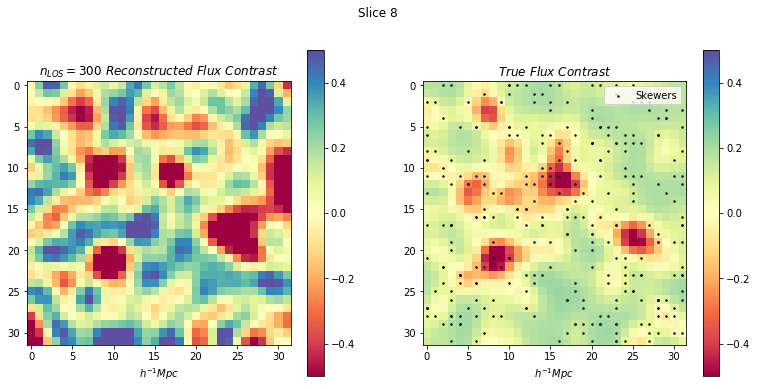

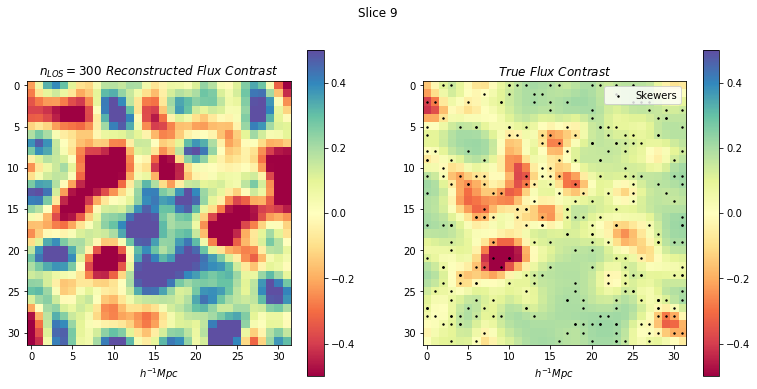

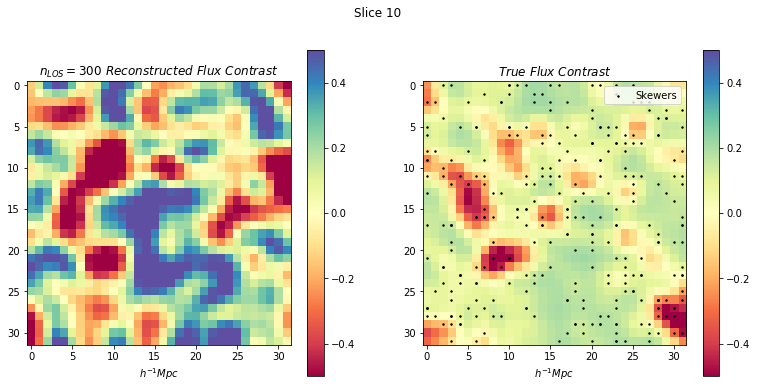

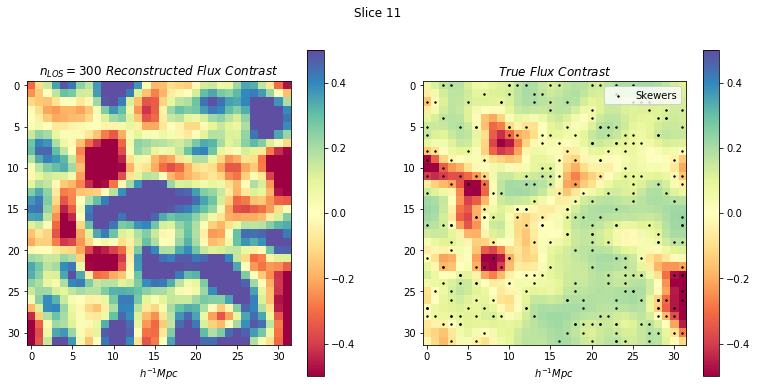

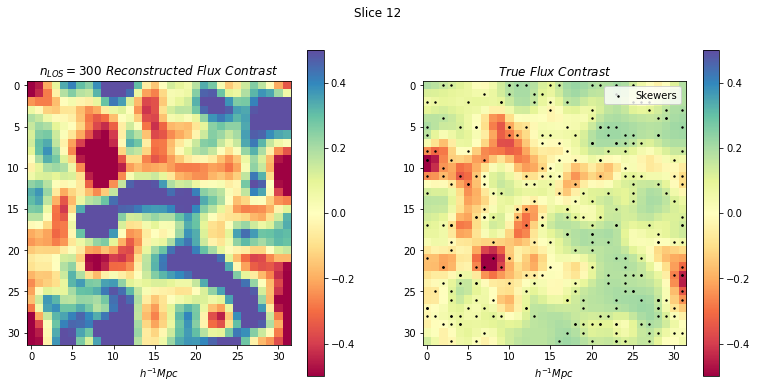

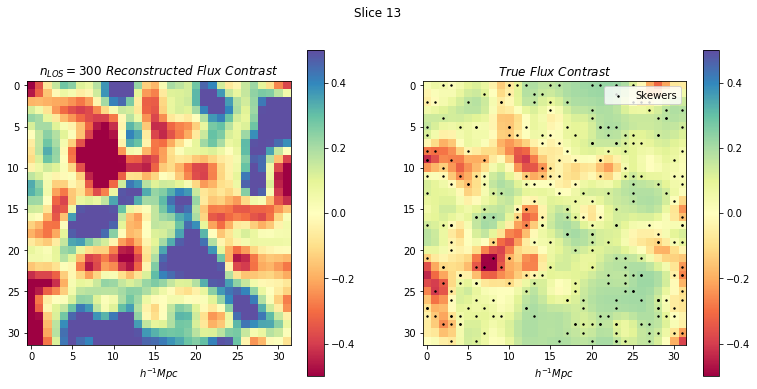

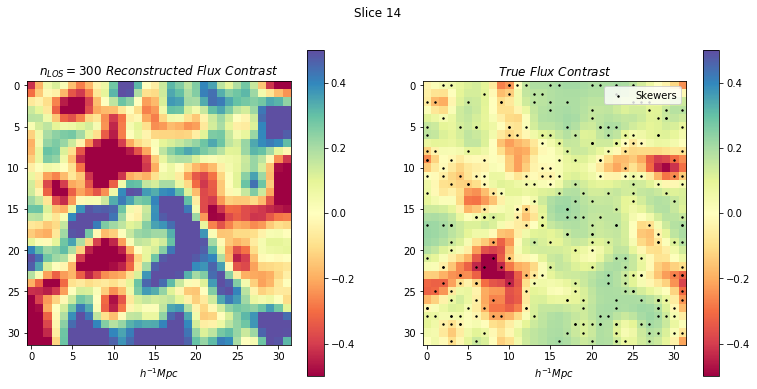

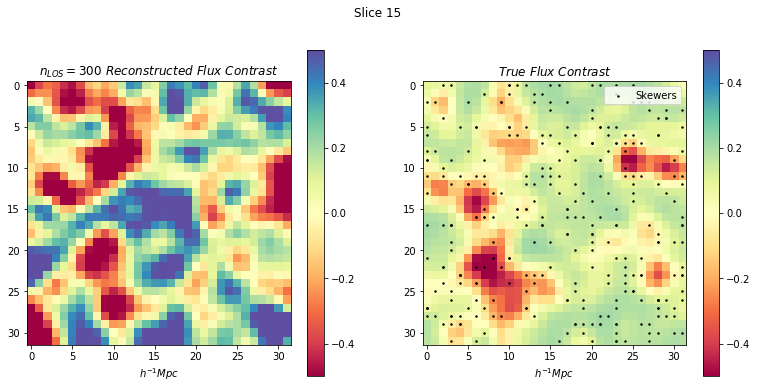

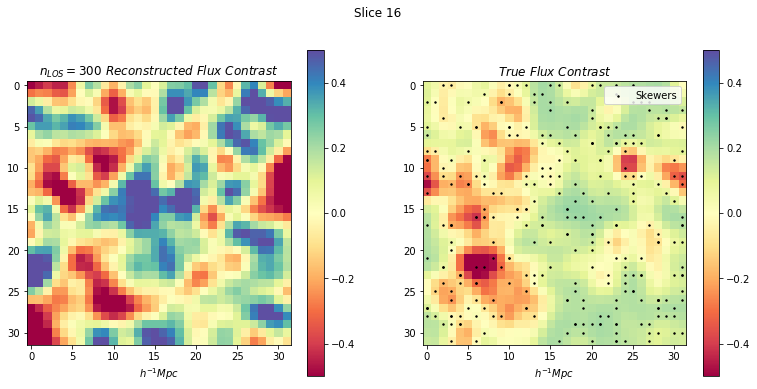

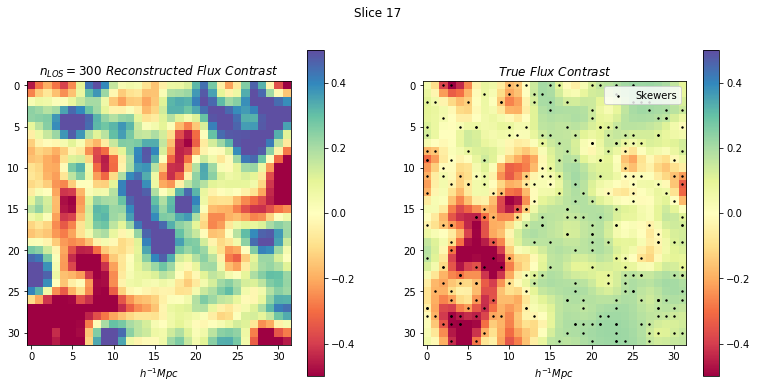

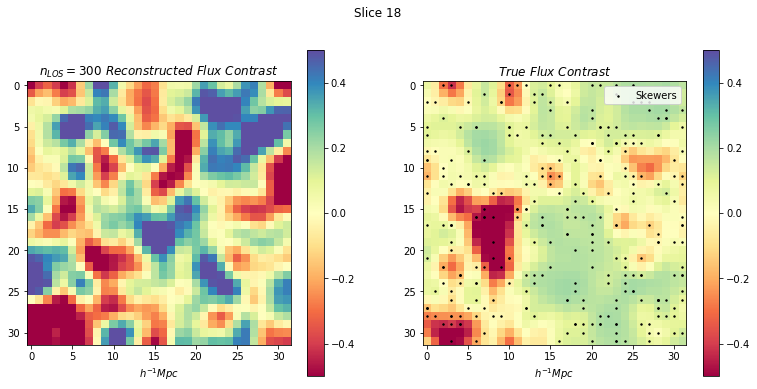

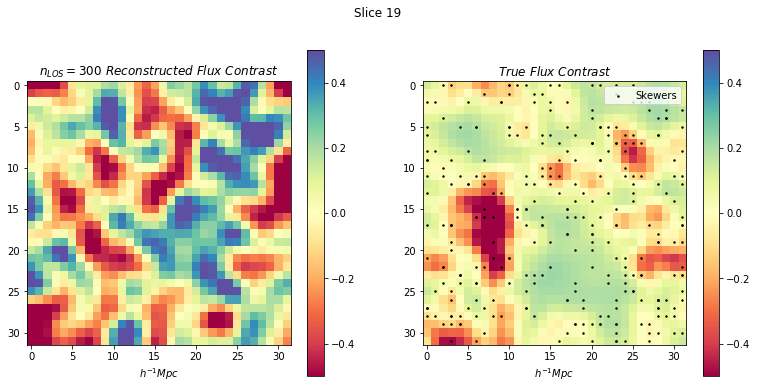

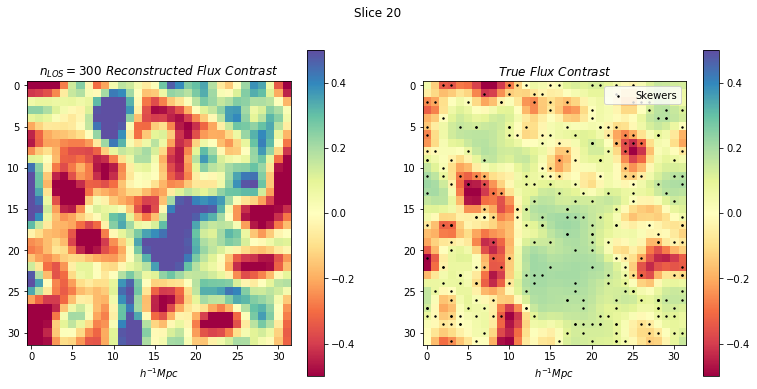

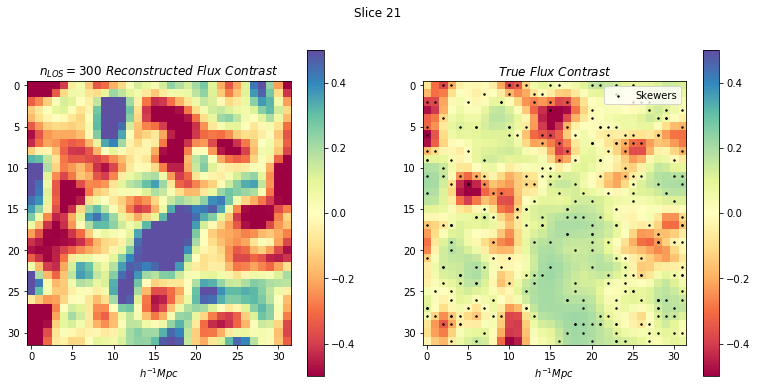

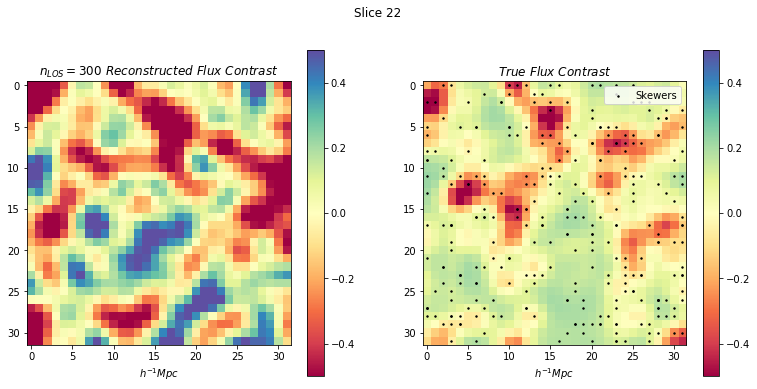

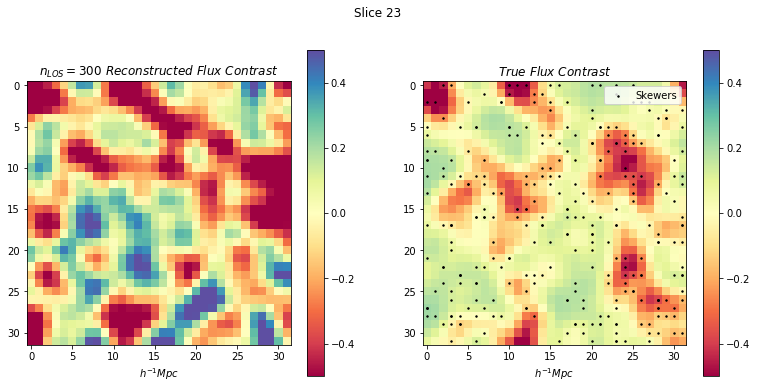

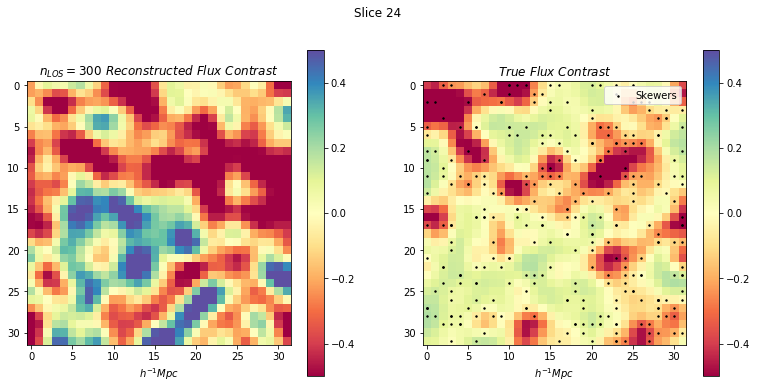

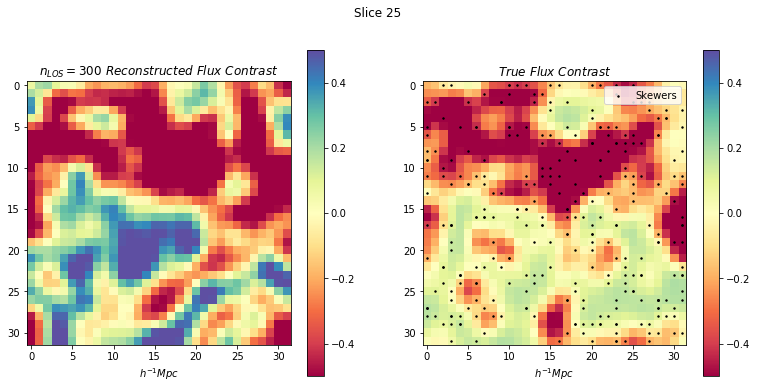

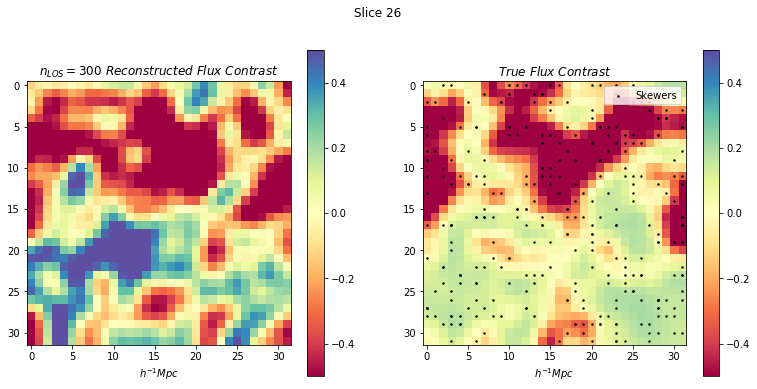

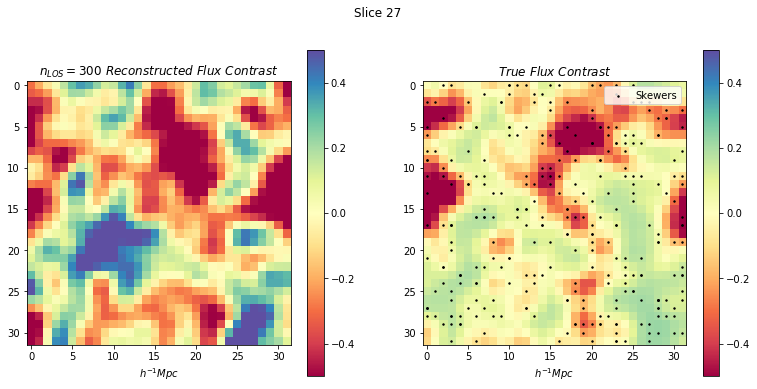

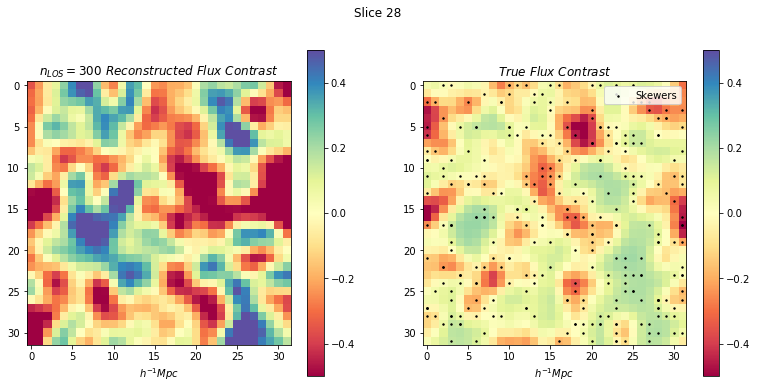

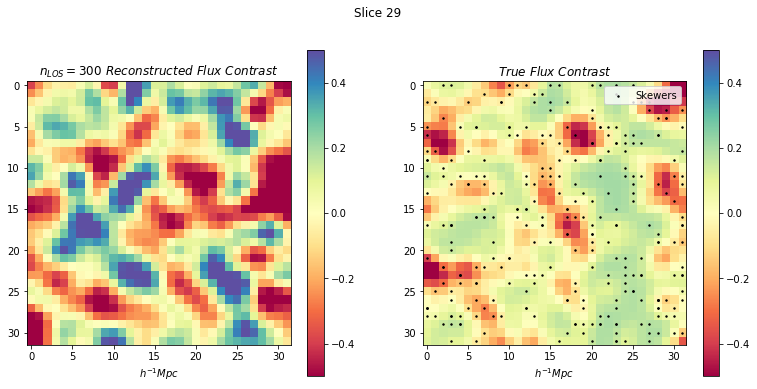

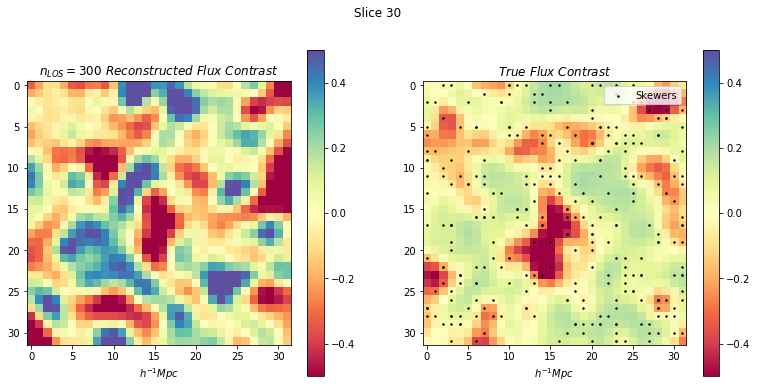

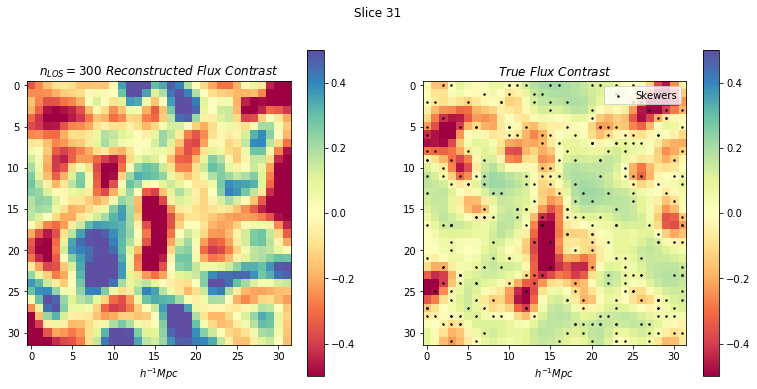

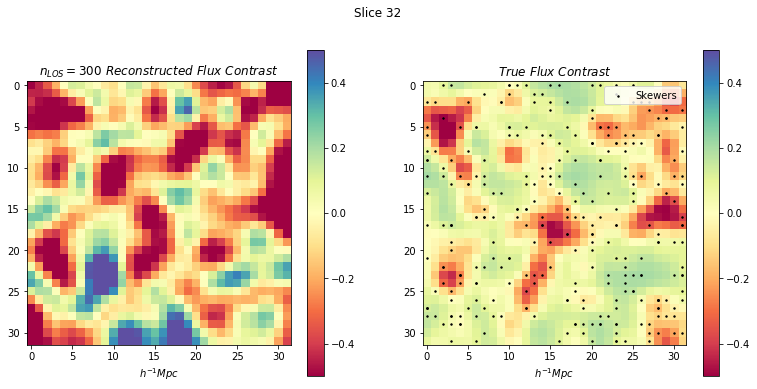

In [50]:
for i in range(n):
    
    fig = figure(figsize=(13,6))
    ax1 = fig.add_subplot(121)
    f1 = M_final[:,:,i]
    surf1 = ax1.imshow(ndimage.gaussian_filter(f1/mean(M_final)-1,1).T,vmin=-0.5,vmax=0.5,cmap="Spectral")
    ax1.set_xlabel(r'$h^{-1}Mpc$')
    ax1.set_title(r'$n_{LOS}=300\ Reconstructed\ Flux\ Contrast$')
    colorbar(surf1,ax=ax1)
    fig.suptitle('Slice %d'%(i+1))
    ax2 = fig.add_subplot(122)
    f2 = exp(-uni.final_tau_RSD[0,:,:,i])
    surf2 = ax2.imshow(ndimage.gaussian_filter(f2/mean(exp(-uni.final_tau_RSD))-1,1),vmin=-0.5,vmax=0.5,cmap="Spectral")
    ax2.set_xlabel(r'$h^{-1}Mpc$')
    ax2.set_title(r'$True\ Flux\ Contrast$')
    ax2.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],c="black",s=2,label='Skewers')
    ax2.legend(loc=1)
    colorbar(surf2,ax=ax2)
    show()

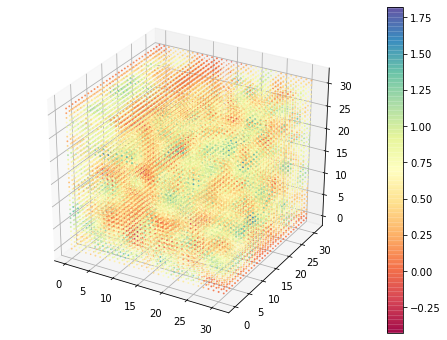

In [40]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
# F=exp(-M)
cbar = ax1.scatter(X,Y,Z,c=M_final.flatten(),alpha=0.8,s=F,cmap='Spectral',marker='o')
colorbar(cbar,ax=ax1)
show()